In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functions import train_test, RMSE, MAE

In [4]:
def TD_MF(R, training_values, time_matrix, days=365, latent_features=10, steps=100, alpha=0.01, reg=0.15):
    min_time = time_matrix[time_matrix > 0].reshape(-1,).min()
    time_index = time_matrix - min_time
    time_index = time_index//(days*24*3600)
    time_index[time_index < 0] = -1
    time_index = time_index.astype(int)
    
    list_size = time_index.max() + 1 
    
    total_rating = 0
    for u,i in training_values:
        total_rating += R[u, i]
    
    avg_rating = total_rating/len(training_values)
    
    P = [np.random.rand(R.shape[0], latent_features) for i in range(list_size)]
    Q = np.random.rand(R.shape[1], latent_features)
    
    bias_user = [np.random.rand(R.shape[0]) for _ in range(list_size)]
    bias_movie = [np.random.rand(R.shape[1]) for _ in range(list_size)]
    
    for _ in range(steps):
        for u,i in training_values:
            ind = time_index[u,i]

            e = R[u, i] - np.dot(P[ind][u], Q[i]) - avg_rating - bias_user[ind][u] - bias_movie[ind][i]

            P[ind][u] = P[ind][u] + alpha*(e*Q[i] - reg*P[ind][u])
            Q[i] = Q[i] + alpha*(e*P[ind][u] - reg*Q[i])
            bias_user[ind][u] = bias_user[ind][u] + alpha*(e - reg*bias_user[ind][u])
            bias_movie[ind][i] = bias_movie[ind][i] + alpha*(e - reg*bias_movie[ind][i])
    
    R_pred = []
    
    for ind in range(list_size):
        R_pred.append(np.dot(P[ind],Q.T) + avg_rating + bias_user[ind].reshape(-1,1) + bias_movie[ind].reshape(1,-1))
    
    return R_pred, time_index

In [25]:
def build_matrix(R_pred, time_index):
    R_ = np.zeros((time_index.shape[0], time_index.shape[1]))

    for u in range(time_index.shape[0]):
        for i in range(time_index.shape[1]):
            ind = time_index[u,i]

            if ind != -1:
                R_[u, i] = R_pred[ind][u, i]
    
    return R_

In [5]:
time_df = pd.read_csv('data/rating_time.csv')
time_data= np.array(time_df)

ratings_df = pd.read_csv('data/user_rating_pt.csv')
R = np.array(ratings_df)

In [6]:
known = []
for u in range(R.shape[0]):
    for i in range(R.shape[1]):
        if R[u,i] > 0:
            known.append((u, i))

training, testing = train_test(known)

In [22]:
R_pred, time_index = TD_MF(R, training, time_data, latent_features=15, days=100, steps=100)

In [27]:
RMSE(R, R1, testing)

0.949289045526049

In [28]:
feature_list = [15, 25, 50, 100, 150]
year_list = [12, 6, 3]

RSME_values = {}

for year in year_list:
    RSME_list = []
    
    for feature in feature_list:
        R_pred, time_index = TD_MF(R, training, time_data, latent_features=feature, days=int(year*365))
        R_ = build_matrix(R_pred, time_index)
        
        RMSE_val = RMSE(R, R_, testing)
        RSME_list.append(RMSE_val)
    
    RSME_values[year] = RSME_list
    print(RMSE_val)

0.8614970954271876
0.8774211743176218
0.8978633095257559


In [31]:
year_list2 = [1, .5, .25]

for year in year_list2:
    RSME_list = []
    
    for feature in feature_list:
        R_pred, time_index = TD_MF(R, training, time_data, latent_features=feature, days=int(year*365))
        R_ = build_matrix(R_pred, time_index)
        
        RMSE_val = RMSE(R, R_, testing)
        RSME_list.append(RMSE_val)
    
    RSME_values[year] = RSME_list
    print(RMSE_val)

0.9357885834372384
0.9997595297569077
1.088019378808346


In [37]:
RMSE_df = pd.DataFrame(RSME_values, index=feature_list)

RMSE_df

,12.00,6.00,3.00,1.00,0.50,0.25
15,0.864374,0.875123,0.898168,0.923618,0.938534,0.953505
25,0.861997,0.876420,0.893915,0.926467,0.941382,0.954563
50,0.858889,0.872359,0.892044,0.926040,0.949855,0.975713
100,0.861654,0.875501,0.897143,0.928172,0.976540,1.023292
150,0.861497,0.877421,0.897863,0.935789,0.999760,1.088019


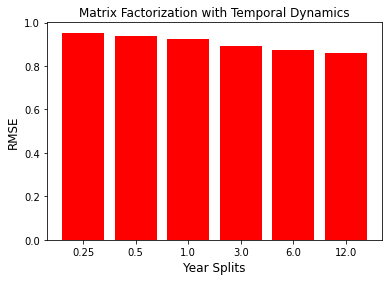

In [54]:
min_values = RMSE_df.min().sort_index()
year_index = min_values.index.astype('str')

plt.bar(year_index, min_values, color='red')

plt.title("Matrix Factorization with Temporal Dynamics", size=12)
plt.xlabel("Year Splits", size=12)
plt.ylabel("RMSE", size=12)

plt.show()

In [40]:
RMSE_df.loc[15,]

12.00    0.864374
6.00     0.875123
3.00     0.898168
1.00     0.923618
0.50     0.938534
0.25     0.953505
Name: 15, dtype: float64

In [9]:
min_time = time_data[time_data>0].reshape(-1,).min()
td = time_data - min_time
td = td//(3650*24*3600) #4272
td[td < 0] = -1

max_ind = int(td.reshape(-1,).max())
for ind in range(max_ind + 1):
    print(ind, ":", np.sum(td == ind))

0 : 42060
1 : 38862
2 : 19914
